In [1]:
import pandas as pd
from pycirclize import Circos
from pycirclize.parser import Matrix

from pathlib import Path

import sys

sys.path.append("../scripts")

from shared import IVY_COLORS
from lcc import LCC_CLASSIFICATION, LCC_TO_AREA, LCC_TOP_CLASSIFICATION

In [2]:
df = pd.read_csv("../data/derived/all_records.csv")
df.head()

,Date,System,From,To,OriginLocation,DestinationLocation,Type,CallNumber
0,2023-09-17 22:54:42 UTC,BorrowDirect,University of Chicago,Dartmouth College,Social Work Library,Baker-Berry,Non-article,E185.86.H379 2019
1,2023-09-17 22:54:42 UTC,BorrowDirect,Cornell University,Dartmouth College,Olin Library,Baker-Berry,Non-article,E185.86 .H379 2019
2,2023-12-11 13:49:24 UTC,BorrowDirect,Yale University,Dartmouth College,"SML, Stacks, LC Classification",Baker-Berry,Non-article,BV823 .C627X 2014 (LC)
3,2023-12-30 23:03:49 UTC,BorrowDirect,Duke University,Dartmouth College,Perkins/Bostock Library,Baker-Berry,Non-article,DE1 .S7833 v.1-4
4,2023-12-29 20:12:26 UTC,BorrowDirect,University of Chicago,Dartmouth College,Regenstein,Baker-Berry,Non-article,HQ1064.U5 M395 1997


In [3]:
link_cmap = []
for partner, color in IVY_COLORS.items():
    link_cmap.append(("Dartmouth College", partner, color))

In [4]:
institutions = [
    "Brown University",
    "Columbia University Libraries",
    "Cornell University",
    "Duke University",
    "Harvard University",
    "Johns Hopkins University",
    "Massachusetts Institute of Technology",
    "Princeton University",
    "Stanford University",
    "University of Pennsylvania",
    "University of Chicago",
    "Yale University",
]

In [5]:
def make_chord(df: pd.DataFrame, order):
    matrix = Matrix.parse_fromto_table(df)
    circos = Circos.initialize_from_matrix(
        matrix,
        start=-265,
        end=95,
        space=5,
        r_lim=(93, 100),
        # cmap=IVY_COLORS,
        # link_cmap=link_cmap,
        order=order,
        label_kws=dict(
            size=8, color="black", adjust_rotation=True, orientation="vertical"
        ),
        link_kws=dict(ec="black", lw=0.5, direction=1),
    )
    fig = circos.plotfig()
    return fig

## Clean call numbers


In [6]:
df = df.dropna(subset="CallNumber")

df = df[df.CallNumber.apply(lambda x: x[:2].isupper())]

In [7]:
def get_class(lcc: str) -> str:
    return LCC_TOP_CLASSIFICATION.get(lcc[0])


def get_area(lcc: str) -> str:
    return LCC_TO_AREA.get(lcc[0])


def get_subclass(lcc: str) -> str:
    if lcc[:2].isalpha():
        return LCC_CLASSIFICATION.get(lcc[:2])
    if lcc[0].isalpha():
        return LCC_CLASSIFICATION.get(lcc[0])
    return None


df["Area"] = df.CallNumber.apply(get_area)
df["Class"] = df.CallNumber.apply(get_class)
df["Subclass"] = df.CallNumber.apply(get_subclass)
df = df.dropna(subset="Subclass")
df

,Date,System,From,To,OriginLocation,DestinationLocation,Type,CallNumber,Area,Class,Subclass
0,2023-09-17 22:54:42 UTC,BorrowDirect,University of Chicago,Dartmouth College,Social Work Library,Baker-Berry,Non-article,E185.86.H379 2019,Humanities,History of the Americas,History of the Americas
1,2023-09-17 22:54:42 UTC,BorrowDirect,Cornell University,Dartmouth College,Olin Library,Baker-Berry,Non-article,E185.86 .H379 2019,Humanities,History of the Americas,History of the Americas
2,2023-12-11 13:49:24 UTC,BorrowDirect,Yale University,Dartmouth College,"SML, Stacks, LC Classification",Baker-Berry,Non-article,BV823 .C627X 2014 (LC),Humanities,"Philosophy, Psychology, Religion",Practical Theology
3,2023-12-30 23:03:49 UTC,BorrowDirect,Duke University,Dartmouth College,Perkins/Bostock Library,Baker-Berry,Non-article,DE1 .S7833 v.1-4,Humanities,World History,Greco-Roman World
4,2023-12-29 20:12:26 UTC,BorrowDirect,University of Chicago,Dartmouth College,Regenstein,Baker-Berry,Non-article,HQ1064.U5 M395 1997,Social Sciences,Social Sciences,"The family, Marriage, Women"
...,...,...,...,...,...,...,...,...,...,...,...
17960,2023-11-09 13:41:23.963000,RAPID,Dartmouth College,Cornell University,Baker-Berry Library Stacks,NEW: Olin,Article,ML3795 .V607 2023,Music and Arts,Music and Books on Music,Literature on music
17963,2023-11-10 01:11:25.380000,RAPID,Dartmouth College,Harvard University,Baker-Berry Library Stacks,NEW: Widener Library,Article,KBP56 .H46 2021,Social Sciences,Law,Religious law in general. Comparative religiou...
17965,2023-11-10 14:21:28.027000,RAPID,Dartmouth College,Princeton University,BAKER STACKS,"NEW: Interlibrary Services, Firestone",Article,HQ18.55 .S25 2023,Social Sciences,Social Sciences,"The family, Marriage, Women"
17969,2023-11-12 22:38:07.450000,RAPID,Dartmouth College,Cornell University,Baker,NEW: Olin,Article,CN1 .J68 v.3 2020,Humanities,Auxiliary Sciences of History,"Inscriptions, Epigraphy"


In [14]:
USE_SUBCLASS = {
    "Humanities": [],
    "Language and Literature": ["Language and Literature"],
    "Medicine": ["Medicine"],
    "Music and Arts": ["Fine Arts"],
    "Reference Works:": ["General Works"],
    "STEM": [],
    "Social Sciences": [],
}

In [15]:
df["GroupingVar"] = df["Class"]
for area, classes in USE_SUBCLASS.items():
    for class_ in classes:
        df.loc[(df.Area == area) & (df.Class == class_), "GroupingVar"] = df.loc[
            (df.Area == area) & (df.Class == class_), "Subclass"
        ]

In [16]:
borrowed = (
    df[(df.To == "Dartmouth College")]
    .groupby(["From", "Area", "GroupingVar"])
    .size()
    .rename("N")
    .reset_index()
)

borrowed = borrowed.rename(columns={"GroupingVar": "To"})
borrowed = borrowed[["From", "Area", "To", "N"]].sort_values(by="From")
borrowed

,From,Area,To,N
0,Brown University,Humanities,Auxiliary Sciences of History,4
20,Brown University,Music and Arts,Architecture,3
21,Brown University,Music and Arts,Arts in general,2
22,Brown University,Music and Arts,Drawing. Design. Illustration,2
23,Brown University,Music and Arts,Fine Arts,10
...,...,...,...,...
439,Yale University,Language and Literature,Slavic. Baltic. Albanian languages,6
440,Yale University,Medicine,Dentistry,1
441,Yale University,Medicine,Internal medicine,5
443,Yale University,Medicine,Otorhinolaryngology,1


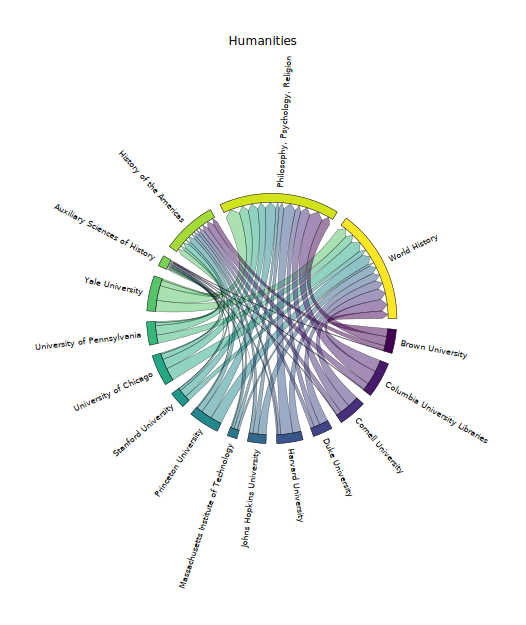

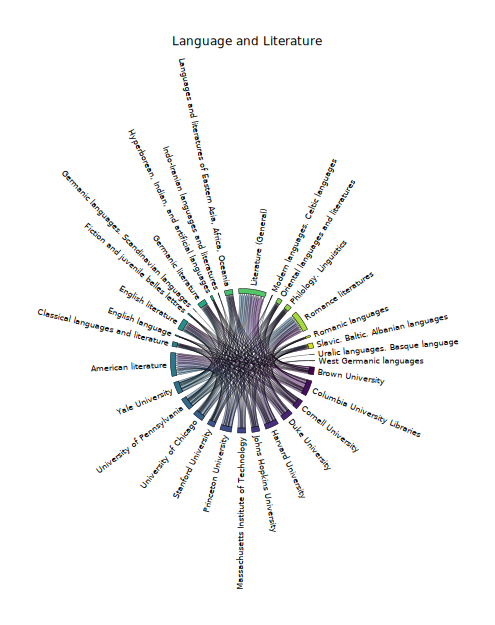

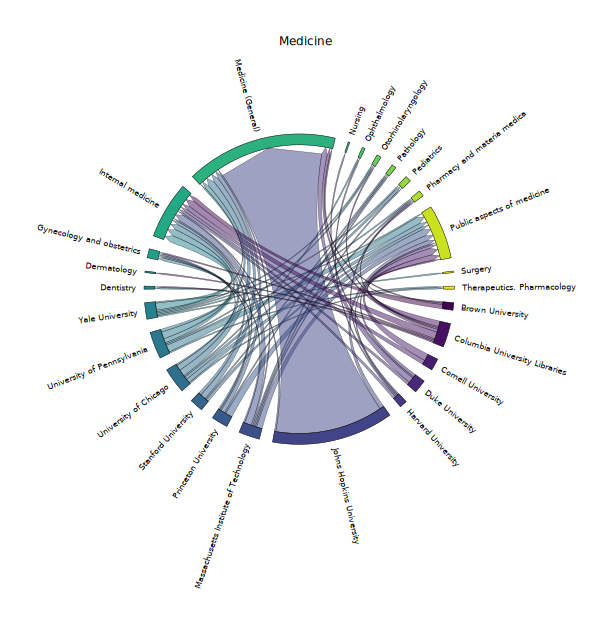

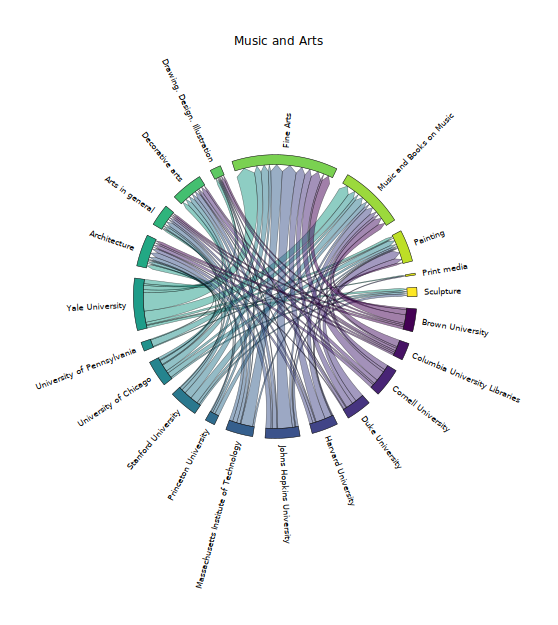

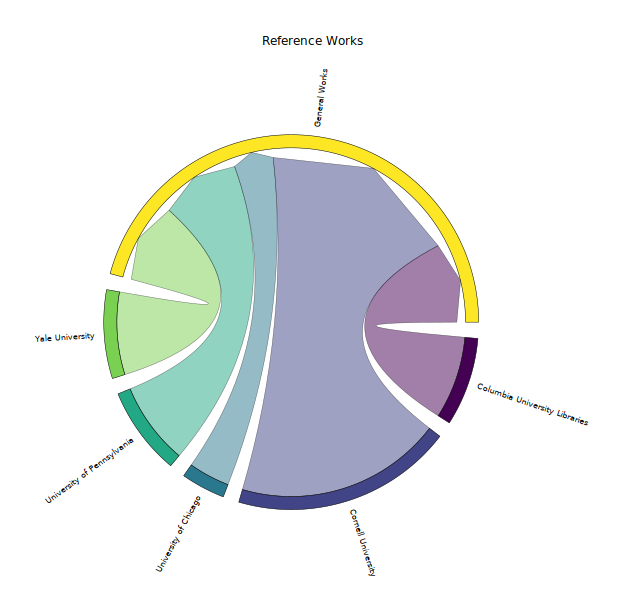

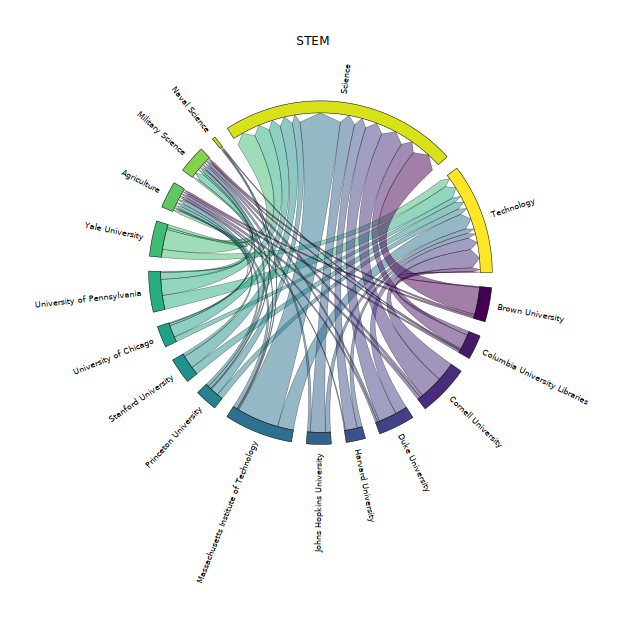

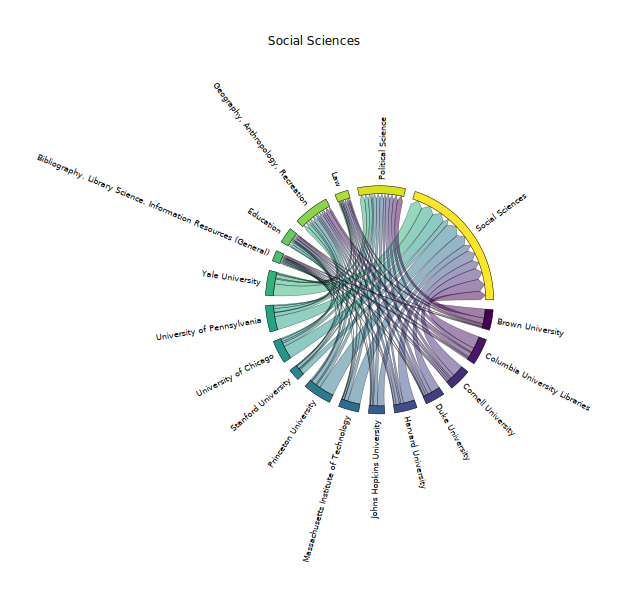

In [17]:
for area, records in borrowed.groupby("Area"):
    order = sorted(records.From.unique()) + sorted(records.To.unique())
    fig = make_chord(records.drop(columns="Area"), order=order)
    # fig.savefig(f"../out/chord-lent-subjectarea-{month.lower()}.png", dpi=300)
    fig.suptitle(area)

In [18]:
lent = (
    df[(df.From == "Dartmouth College")]
    .groupby(["To", "Area", "GroupingVar"])
    .size()
    .rename("N")
    .reset_index()
)
lent = lent.rename(columns={"GroupingVar": "From"})
lent = lent[["From", "Area", "To", "N"]]
lent

,From,Area,To,N
0,Auxiliary Sciences of History,Humanities,Brown University,5
1,History of the Americas,Humanities,Brown University,29
2,"Philosophy, Psychology, Religion",Humanities,Brown University,54
3,World History,Humanities,Brown University,40
4,American literature,Language and Literature,Brown University,35
...,...,...,...,...
509,Education,Social Sciences,Yale University,17
510,"Geography, Anthropology, Recreation",Social Sciences,Yale University,44
511,Law,Social Sciences,Yale University,27
512,Political Science,Social Sciences,Yale University,39


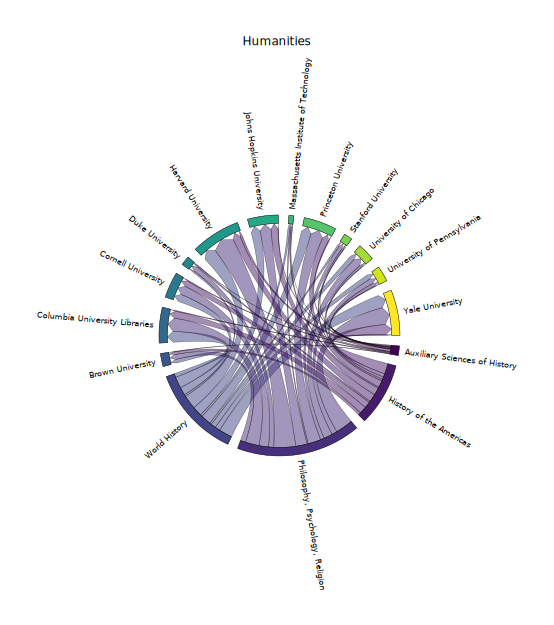

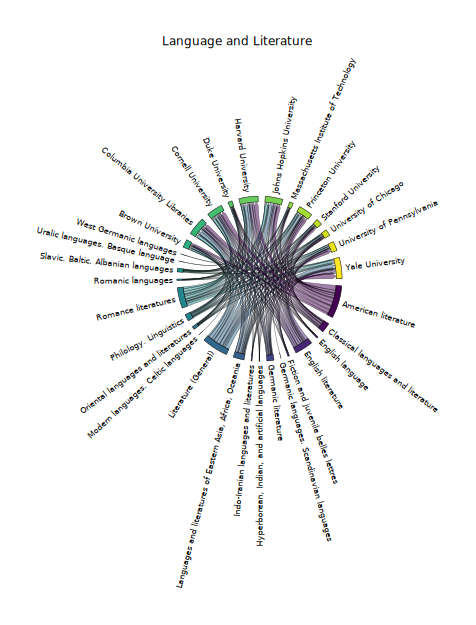

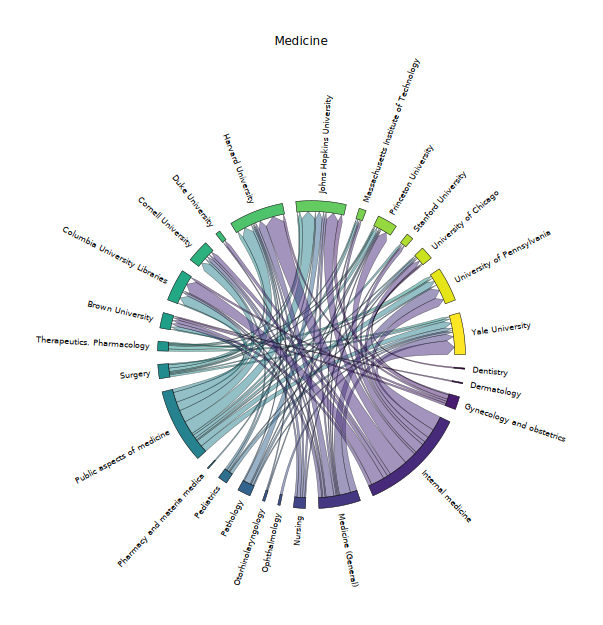

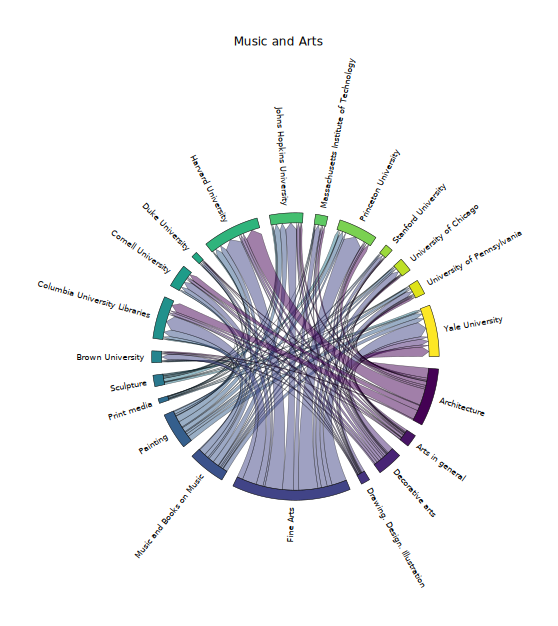

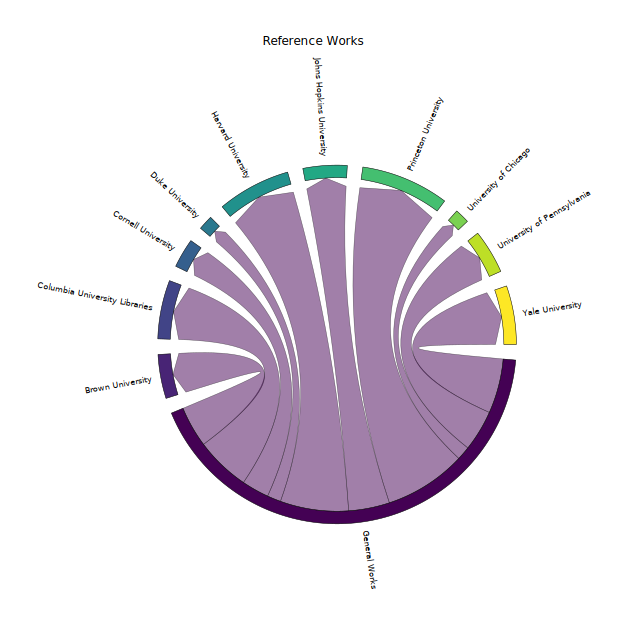

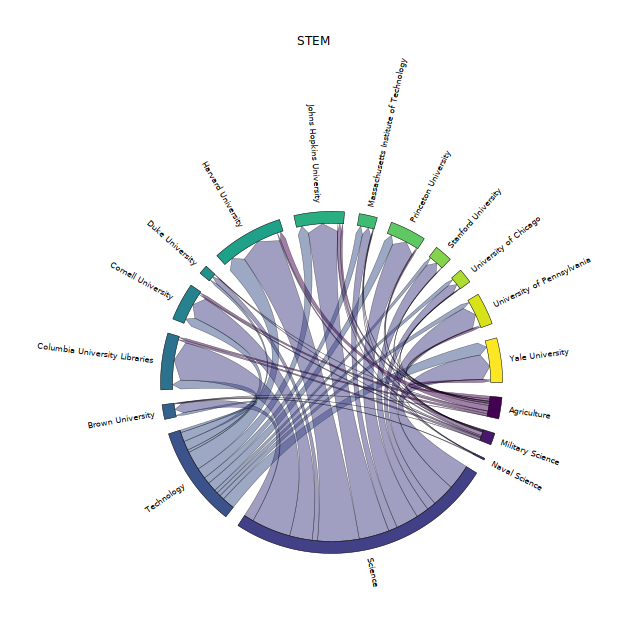

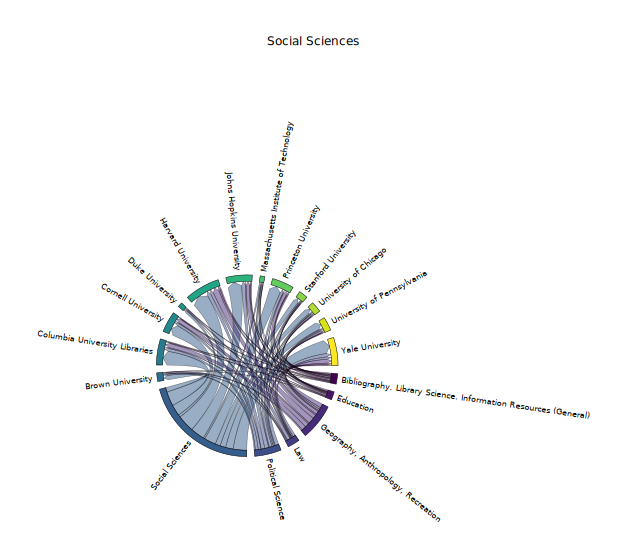

In [19]:
for area, records in lent.groupby("Area"):
    order = sorted(records.From.unique()) + sorted(records.To.unique())
    fig = make_chord(records.drop(columns="Area"), order=order)
    # fig.savefig(f"../out/chord-lent-subjectarea-{month.lower()}.png", dpi=300)
    fig.suptitle(area)